In [1]:
# https://machinelearningmastery.com/time-series-prediction-with-deep-learning-in-python-with-keras/
    
import sys
import math

# !{sys.executable} -m pip install --upgrade pip

try:
    import numpy as np
except ModuleNotFoundError:
    !{sys.executable} -m pip install numpy
    import numpy as np
    

try:
    import pandas as pd
except ModuleNotFoundError:
    !{sys.executable} -m pip install pandas
    import pandas as pd

    
try:
    import matplotlib
    import matplotlib.pyplot as plt
except ModuleNotFoundError:
    !{sys.executable} -m pip install matplotlib
    import matplotlib.pyplot as plt

    
try:
    import psycopg2
except ModuleNotFoundError:
    !{sys.executable} -m pip install psycopg2
    import psycopg2
    
    
try:
    import scipy
except ModuleNotFoundError:
    !{sys.executable} -m pip install scipy
    import scipy

        
try:
    import sklearn
except ModuleNotFoundError:
    !{sys.executable} -m pip install sklearn
    import sklearn

    
try:
    import statsmodels
except ModuleNotFoundError:
    !{sys.executable} -m pip install statsmodels
    import statsmodels


try:
    import theano
except ModuleNotFoundError:
    !{sys.executable} -m pip install theano
    import theano


try:
    import tensorflow
except ModuleNotFoundError:
    !{sys.executable} -m pip install tensorflow
    import tensorflow


try:
    import keras
except ModuleNotFoundError:
    !{sys.executable} -m pip install keras
    import keras
    
try:
    import ann_visualizer
except ModuleNotFoundError:
    import sys
    !{sys.executable} -m pip install ann_visualizer
    import ann_visualizer
    
try:
    import graphviz
except ModuleNotFoundError:
    !{sys.executable} -m pip install graphviz
    import graphviz
    
    
from keras.models import Sequential
from keras.layers import Dense

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\ProgramData\Anaconda3\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv im

In [2]:
"""
Make plot outputs appear and be stored within the notebook
"""
%matplotlib inline

"""
fix random seed for reproducibility
"""
np.random.seed(7)

In [3]:
from numpy import genfromtxt

def get_df():
    """
    Query the Postgres database and return the data set in a Pandas dataframe with (x,y)
    """
    
    # conn = psycopg2.connect(DATABASE_URL)
    # cur = conn.cursor()
    # cur.execute('select * from project2')
    data = genfromtxt(r"C:\Users\cccarmer\Documents\asu\EEE 511\code\proj3\data.csv")
    df = pd.DataFrame(data, columns=['y'])
    # conn.commit()
    # conn.close()
    
    return df


In [4]:
from keras.models import Sequential
from keras.layers.recurrent import LSTM, SimpleRNN
from keras.layers.core import Dense, Activation, Dropout
from keras.utils.vis_utils import plot_model

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle

data = get_df()

# Get the raw data values from the pandas data frame.
dataset = data.values.astype("float32")

# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

184 91


In [5]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [6]:
# reshape into X=t and Y=t+1
look_back = 2
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [7]:
%%capture
# create and fit Multilayer Perceptron model
model = Sequential()
model.add(Dense(8, input_dim=look_back, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=200, batch_size=2, verbose=2)


In [8]:
# Estimate model performance
trainScore = model.evaluate(trainX, trainY, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))
testScore = model.evaluate(testX, testY, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore)))

Train Score: 191.74 MSE (13.85 RMSE)
Test Score: 301.91 MSE (17.38 RMSE)


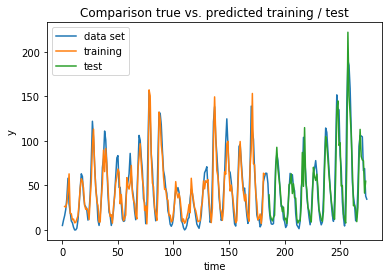

In [9]:
# generate predictions for training
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
plt.plot(dataset, label = 'data set')
plt.plot(trainPredictPlot, label = 'training')
plt.plot(testPredictPlot, label = 'test')
plt.xlabel("time")
plt.ylabel("y")
plt.title("Comparison true vs. predicted training / test")
plt.legend()
plt.show()